In [2]:
%matplotlib inline
%load_ext memory_profiler

import os, sys, glob, re, math, pickle
import phate,scprep,magic,meld
import graphtools as gt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import time,random,datetime
from sklearn import metrics
from sklearn import model_selection
from scipy import sparse
from scipy.stats import mannwhitneyu, tiecorrect, rankdata
from statsmodels.stats.multitest import multipletests
import scanpy as sc
import scvelo as scv
from adjustText import adjust_text
import warnings



# settings
plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['text.usetex']=False
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=0.5
sc.set_figure_params(dpi=300,dpi_save=600,
                     frameon=False,
                     fontsize=9)
plt.rcParams['savefig.dpi']=600
sc.settings.verbosity=2
sc._settings.ScanpyConfig.n_jobs=-1
scv.settings.n_jobs=-1
sns.set_style("ticks")


In [3]:

# fps
dfp = '/home/ngr4/project/scnd/data/'
pfp = '/home/ngr4/project/scnd/results/'
pdfp = '/home/ngr4/project/scnd/data/processed/'
sc.settings.figdir = pfp
scv.settings.figdir = pfp


def loader(fname,fpath,backed=None) : 
    start = time.time()
    adata = sc.read_h5ad(filename=os.path.join(fpath,fname),backed=backed)
    print('loaded @'+datetime.datetime.now().strftime('%y%m%d.%H:%M:%S'))
    print('took {:.2f}-s to load data'.format(time.time()-start))
    return adata

def writer(fname,fpath,AnnData) :
    start = time.time()
    Anndata.write(os.path.join(fpath,fname))
    print('saved @'+datetime.datetime.now().strftime('%y%m%d.%H:%M:%S'))
    print('took {:.2f}-s to save data'.format(time.time()-start))
    

if False :
    # load human
    fname='hum_MT_bbknn.h5ad'
    %memit hdata = loader(fname,pdfp)
    
if True :
    # load mouse
    fname='mouse_MT_bbknn.h5ad'
    %memit mdata = loader(fname,pdfp)


loaded @200418.16:40:32
took 164.21-s to load data
peak memory: 149471.25 MiB, increment: 149265.62 MiB


In [7]:
channels = pd.read_csv(os.path.join(pfp,'channels.csv'))
channels = channels.dropna()
dict_temp = {}
for i,fam in enumerate(channels['Family name'].unique()):
    dict_temp[fam] = channels.loc[channels['Family name']==fam,'MGI symbol'].to_list()
channels = dict_temp
del dict_temp

In [25]:
channels ={
    'Voltage-gated calcium channels': ['Cacna1a',
      'Cacna1b',
      'Cacna1c',
      'Cacna1d',
      'Cacna1e',
      'Cacna1f',
      'Cacna1g',
      'Cacna1h',
      'Cacna1i',
      'Cacna1s'],
     'CatSper and Two-Pore channels': ['Catsper1',
      'Catsper2',
      'Catsper3',
      'Catsper4',
      'Tpcn1',
      'Tpcn2'],
     'Cyclic nucleotide-regulated channels': ['Cnga1',
      'Cnga2',
      'Cnga3',
      'Cnga4',
      'Cngb1',
      'Cngb3',
      'Hcn1',
      'Hcn2',
      'Hcn3',
      'Hcn4'],
     'Voltage-gated proton channel': ['Hvcn1'],
     'Voltage-gated potassium channels': ['Kcna1',
      'Kcna10',
      'Kcna2',
      'Kcna3',
      'Kcna4',
      'Kcna5',
      'Kcna6',
      'Kcna7',
      'Kcnb1',
      'Kcnb2',
      'Kcnc1',
      'Kcnc2',
      'Kcnc3',
      'Kcnc4',
      'Kcnd1',
      'Kcnd2',
      'Kcnd3',
      'Kcnf1',
      'Kcng1',
      'Kcng2',
      'Kcng3',
      'Kcng4',
      'Kcnh1',
      'Kcnh2',
      'Kcnh3',
      'Kcnh4',
      'Kcnh5',
      'Kcnh6',
      'Kcnh7',
      'Kcnh8',
      'Kcnq1',
      'Kcnq2',
      'Kcnq3',
      'Kcnq4',
      'Kcnq5',
      'Kcns1',
      'Kcns2',
      'Kcns3',
      'Kcnv1',
      'Kcnv2'],
     'Inwardly rectifying potassium channels': ['Kcnj1',
      'Kcnj10',
      'Kcnj11',
      'Kcnj12',
      'Kcnj13',
      'Kcnj14',
      'Kcnj15',
      'Kcnj16',
      'Kcnj2',
      'Kcnj3',
      'Kcnj4',
      'Kcnj5',
      'Kcnj6',
      'Kcnj8',
      'Kcnj9'],
     'Two P domain potassium channels': ['Kcnk1',
      'Kcnk10',
      'Kcnk12',
      'Kcnk13',
      'Kcnk15',
      'Kcnk16',
      'Kcnk18',
      'Kcnk2',
      'Kcnk3',
      'Kcnk4',
      'Kcnk5',
      'Kcnk6',
      'Kcnk7',
      'Kcnk9'],
     'Calcium- and sodium-activated potassium channels': ['Kcnma1',
      'Kcnn1',
      'Kcnn2',
      'Kcnn3',
      'Kcnn4',
      'Kcnt1',
      'Kcnt2',
      'Kcnu1'],
     'Transient Receptor Potential channels': ['Mcoln1',
      'Mcoln2',
      'Mcoln3',
      'Pkd2',
      'Pkd2l1',
      'Pkd2l2',
      'Trpa1',
      'Trpc1',
      'Trpc3',
      'Trpc4',
      'Trpc5',
      'Trpc6',
      'Trpc7',
      'Trpm1',
      'Trpm2',
      'Trpm3',
      'Trpm4',
      'Trpm5',
      'Trpm6',
      'Trpm7',
      'Trpm8',
      'Trpv1',
      'Trpv2',
      'Trpv3',
      'Trpv4',
      'Trpv5',
      'Trpv6'],
     'Ryanodine receptors': ['Ryr1', 'Ryr2', 'Ryr3'],
     'Voltage-gated sodium channels': ['Scn10a',
      'Scn11a',
      'Scn1a',
      'Scn2a',
      'Scn3a',
      'Scn4a',
      'Scn5a',
      'Scn8a',
      'Scn9a'],
     'Acid-sensing (proton-gated) ion channels (ASICs)': ['Asic1',
      'Asic2',
      'Asic3'],
     'Nicotinic acetylcholine receptors': ['Chrna1',
      'Chrna10',
      'Chrna2',
      'Chrna3',
      'Chrna4',
      'Chrna5',
      'Chrna6',
      'Chrna7',
      'Chrna9',
      'Chrnb1',
      'Chrnb2',
      'Chrnb3',
      'Chrnb4',
      'Chrnd',
      'Chrne',
      'Chrng'],
     'GABA receptors': ['Gabra1',
      'Gabra2',
      'Gabra3',
      'Gabra4',
      'Gabra5',
      'Gabra6',
      'Gabrb1',
      'Gabrb2',
      'Gabrb3',
      'Gabrd',
      'Gabre',
      'Gabrg1',
      'Gabrg2',
      'Gabrg3',
      'Gabrp',
      'Gabrq',
      'Gabrr1',
      'Gabrr2',
      'Gabrr3'],
     'Glycine receptors': ['Glra1', 'Glra2', 'Glra3', 'Glra4', 'Glrb'],
     'Ionotropic glutamate receptors': ['Gria1',
      'Gria2',
      'Gria3',
      'Gria4',
      'Grid1',
      'Grid2',
      'Grik1',
      'Grik2',
      'Grik3',
      'Grik4',
      'Grik5',
      'Grin1',
      'Grin2a',
      'Grin2b',
      'Grin2c',
      'Grin2d',
      'Grin3a',
      'Grin3b'],
     '5-HT receptors': ['Htr3a', 'Htr3b'],
     'IP receptors': ['Itpr1', 'Itpr2', 'Itpr3'],
     'P2X receptors': ['P2rx1',
      'P2rx2',
      'P2rx3',
      'P2rx4',
      'P2rx5',
      'P2rx6',
      'P2rx7'],
     'Epithelial sodium channel (ENaC)': ['Scnn1a', 'Scnn1b', 'Scnn1g']}

In [33]:
# plot EMD
genes = [g for k,v in channels.items() for g in v]
dge = pd.DataFrame()
for i,t in enumerate(['5wk','12wk','18wk','24wk','30wk']):
    
    adata = sc.AnnData(mdata[(mdata.obs['ctype']=='Purkinje cell') & (mdata.obs['timepoint']==t),:])
    adata = sc.AnnData(adata[:,genes])

    X = scprep.stats.differential_expression(np.asarray(adata.layers['imputed_bbknn'][adata.obs['genotype']=='SCA1',:]),
                                             np.asarray(adata.layers['imputed_bbknn'][adata.obs['genotype']=='WT',:]),
                                             measure='emd',
                                             gene_names=adata.var_names,
                                             direction='both',
                                             n_jobs=-1)
    X['t'] = [t]*X.shape[0]
    X['Gene'] =  X.index.to_list()
    
    dge = dge.append(X, ignore_index=True)
dge = dge.drop(columns='rank')
dge = dge.pivot('Gene','t')
dge = dge.drop(columns='rank')
dge = dge.loc[:,['5wk','12wk','18wk','24wk','30wk']]
dge = dge.reindex([g for k,v in channels.items() for g in v])        
    


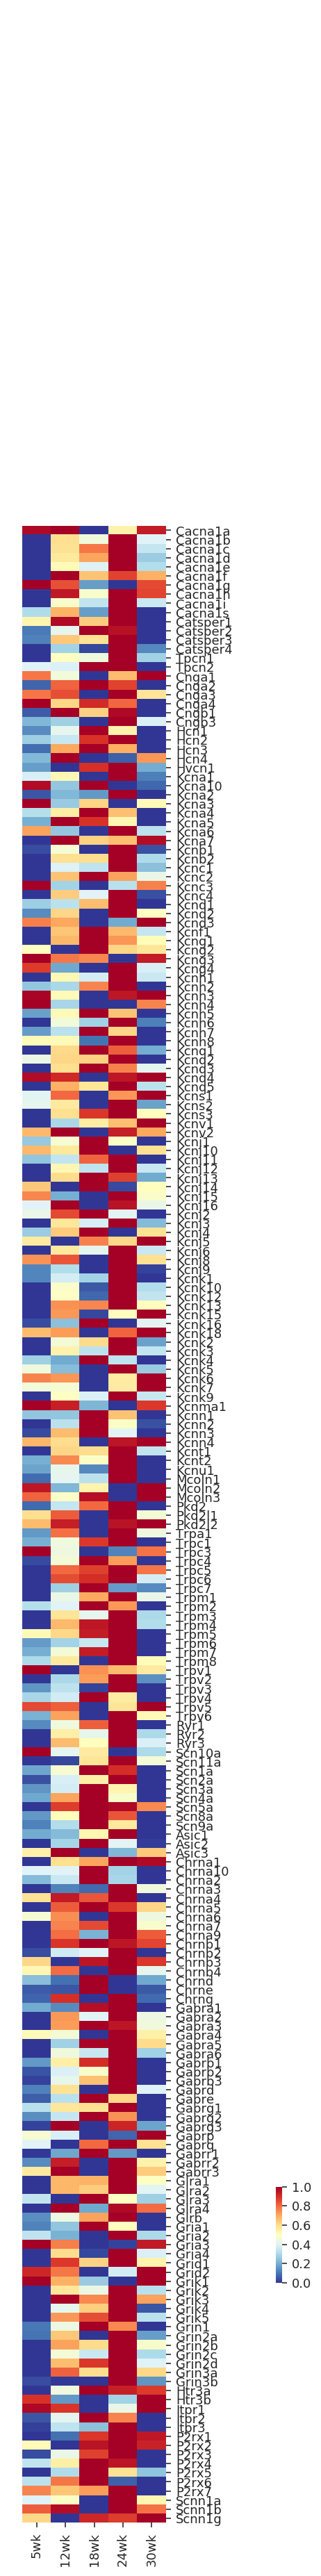

In [91]:
cmin,cmax = round(dge.min(),1),round(X['emd'].max(),1)
p = sns.clustermap(dge, 
                   col_cluster=False, 
                   row_cluster=False,
                   cmap='RdYlBu_r',
#                    vmin=cmin, vmax=cmax,
#                    cbar_kws={'ticks':[cmin,cmax], rotation=''},
                   yticklabels=True,
                   figsize=(2,32),
                   standard_scale=0)
p.ax_heatmap.set_ylabel('')
p.ax_heatmap.set_xlabel('')
p.cax.set_position([1.51, 0.2, 0.03, 0.03])
p.savefig(os.path.join(pfp,'channels.pdf'),bbox_inches='tight')

In [100]:
adata = sc.AnnData(mdata[(mdata.obs['ctype']=='Purkinje cell'),:])
adata = sc.AnnData(adata[:,genes])
adata.obs['gt']=['{}_{}'.format(adata.obs['timepoint'][i],g) for i,g in enumerate(adata.obs['genotype'])]

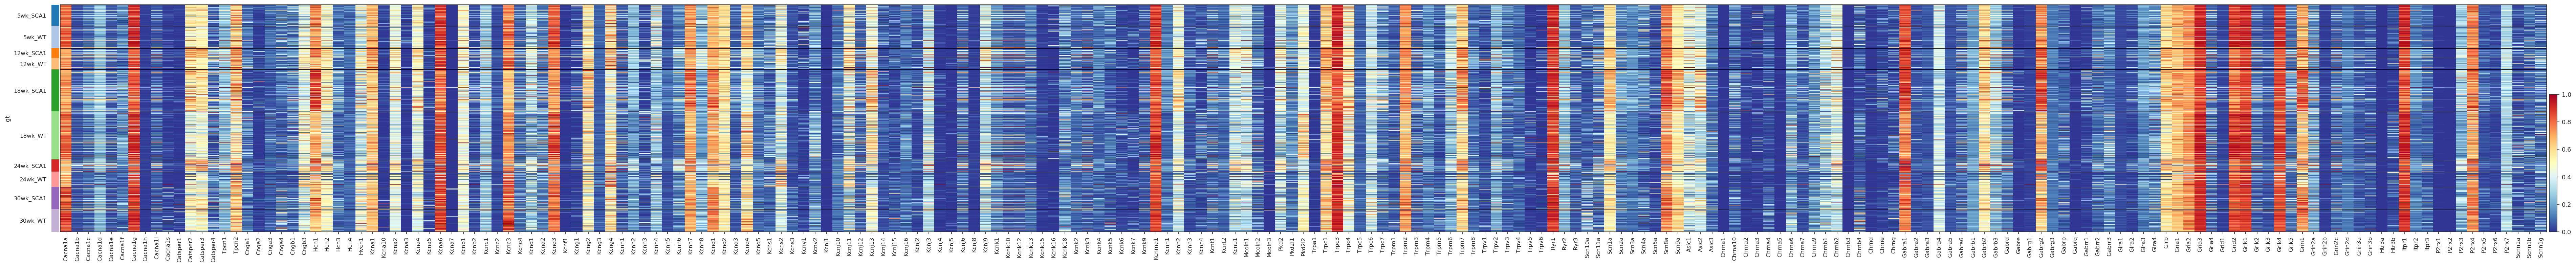

GridSpec(2, 4, height_ratios=[0, 6], width_ratios=[0.2, 65.7, 0, 0.2])

In [108]:
sc.pl.heatmap(adata,
              genes,
              use_raw=False,
              layer='imputed_bbknn',
              groupby='gt',
              standard_scale='var',
              show_gene_labels=True,
              save='_channels.pdf',
              cmap='RdYlBu_r')


In [94]:
for i,t in enumerate(['5wk','12wk','18wk','24wk','30wk']):
    
    adata = sc.AnnData(mdata[(mdata.obs['ctype']=='Purkinje cell'),:])
    adata = sc.AnnData(adata[:,genes])
    
    X 

AnnData object with n_obs × n_vars = 432 × 219 
    obs: 'batch', 'genotype', 'timepoint', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pmito', 'n_genes', 'louvain', 'res_sca1', 'ees_sca1', 'ctype'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'ctype_colors', 'dendrogram_louvain', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_phate', 'X_umap'
    varm: 'PCs'
    layers: 'imputed_bbknn'